In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
from scipy.stats import uniform
from PIL import Image

def draw_egde(a, b, hw=0.0, color="green"):
    # Connect points a and b with an arrow -->
    plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
    head_width=hw, length_includes_head=True, color=color
    )

def make_ring(N, K):
    # N: nodes, K: degree, avg connections per node
    # N: nodes 
    # K: neighbors, K//2 at left, K//2 at right

    # Make ring connectivity
    adj_list = []
    for ni in range(N):
        adj_list += [[]]
        for ki in range(1,K//2+1):
            adj_list[ni] += [ni-ki, ni+ki]

    adj_list = np.array([np.array(ai) for ai in adj_list])

    # Correct borders to create closed condtion
    pos = np.where(adj_list<0)
    adj_list[pos] = adj_list[pos] + N
    pos = np.where(adj_list>=N)
    adj_list[pos] = adj_list[pos] - N

    return adj_list

def plot_circular_layout(adj_list, hw=0.0, rewired_arcs=None):
    t = np.linspace(0, 2*np.pi, N, endpoint=False)  # angle in radians
    # Convert from polar to cartesian 
    x = np.cos(t)
    y = np.sin(t)

    plt.figure(figsize=(8,8))
    plt.plot(x, y, '.', ms=30)
    #a = plt.xlim(-0.1, 2.1)
    #a = plt.ylim(-0.1, 2.1)
    a = plt.axis('off')
    for i in range(N):
        plt.text(x[i]-0.015, y[i]-0.015, i, weight='bold', c='w')
    # a: node of origin, b: destination node. a --> b
    e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw) for a in adj_list for b in adj_list[a]]

    if rewired_arcs is not None:
        e = [draw_egde([x[a], y[a]], [x[b], y[b]], hw, 'red') 
            for a in rewired_arcs for b in rewired_arcs[a]]

def rewire_ring(C, omega):
    # C: adjacecy list, omega: K_r / K, fraction of random shortcuts
    # loop over nodes
    all_nodes = set(range(len(C)))
    for i, ci in enumerate(C):
        # loop over neighborhood
        for j, cj in enumerate(ci):
            # rewire if U(0,1) < omega
            if np.random.random() < omega:
                available_nodes = list(all_nodes - (set([i] + list(ci)) - set([cj])))
                C[i, j] = np.random.choice(available_nodes)

def make_random(N, K):
    # erdos renyi model
    C = []
    for i in range(N):
        C += np.where(np.insert(bernoulli.rvs(K/N, size=(N-1)), i, 0))
    return np.array(C, dtype='object')

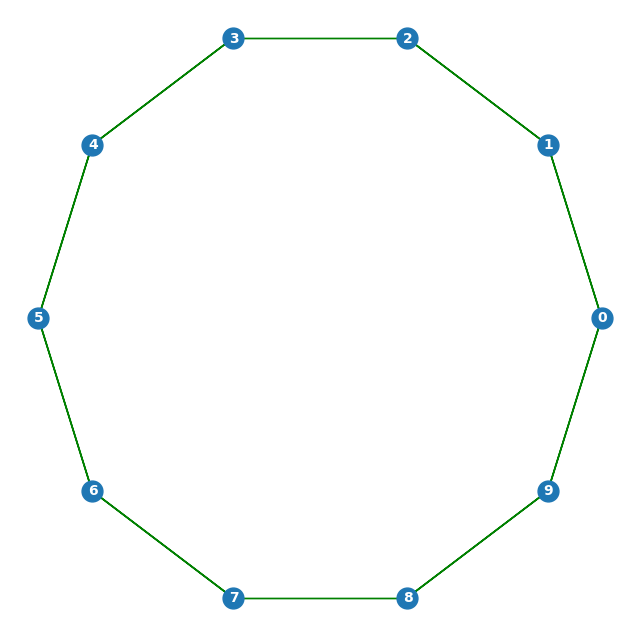

In [ ]:
N = 10
K = 2

C = make_ring(N, K)

adj_list = {ni: C[ni] for ni in range(N)}

plot_circular_layout(adj_list)

### ANN

0. Generate/read/load a set of patterns P
1. Generate network structure, connectivity C, and W=0.
2. **Learning stage:** Learn the pattern set (Hebbian learning)
    - Update Wij += Wij. Commulative.
3. **Retrieval stage**
  3.1 Start network in a learned pattern o close to it. 
  - Noise
  - Fragment
  3.2 Evolve the network to a final state
  3.3 Check the quality of retrieval

### * Biased case
- Normalize the patterns
- Dynamic **retrieval neural threshold** to keep the **activity** of the network
  - $\Theta(h - \theta)$, $h$ is the normalized neural input, $\theta$ is the **neural threshold**.

In [ ]:
# Generate a pattern set 
P = 10  # Ten patterns
X = np.random.randint(2, size=(P, 10))*2-1

X

array([[ 1,  1,  1, -1, -1,  1, -1, -1, -1,  1],
       [-1,  1,  1,  1, -1,  1, -1,  1, -1, -1],
       [-1,  1, -1, -1,  1,  1,  1,  1,  1,  1],
       [ 1, -1, -1,  1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1,  1, -1, -1,  1,  1, -1,  1],
       [ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1, -1,  1,  1,  1,  1,  1],
       [-1, -1,  1,  1, -1, -1, -1,  1, -1,  1],
       [-1,  1,  1,  1, -1, -1, -1,  1, -1,  1],
       [-1, -1, -1, -1, -1, -1,  1,  1, -1, -1]])

In [ ]:
# Overlap between patterns
# We want to measure overlap between network state and intended pattern
(X[0]*(X[2])).mean(), (X[0]*(X[0])).mean(), (X[0]*(-X[0])).mean()

(-0.2, 1.0, -1.0)

In [ ]:
# Learn the patterns: update matrix W
W = np.array([np.zeros(len(C[ni])) for ni in range(N)])

# pattern 0
xi = X[0].copy()
# neruon 0
ni = 0
xi[C[ni]]*xi[ni], C[ni]

(array([1, 1]), array([9, 1]))

In [ ]:
# Learning phase
# Hebbian learning
# for each pattern
# update W matrix, implies iterating over the network
for xi in X:
    for ni in range(N):
        W[ni] += xi[C[ni]]*xi[ni]
W

array([[ 2.,  0.],
       [ 0.,  0.],
       [ 0.,  2.],
       [ 2., -4.],
       [-4.,  2.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2., -2.],
       [-2.,  0.],
       [ 0.,  2.]])

In [ ]:
# Retrieval phase
# Denoising, pattern completion
pi = 0  # pattern 0
states = X[pi].copy()
time = 10
#update network
m = [(states*(X[pi])).mean()]
for ti in range(time):
    # update all neurons
    states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
    m += [(states*(X[pi])).mean()]
m

[1.0, -0.4, 0.6, 0.0, 0.6, 0.0, 0.6, 0.0, 0.6, 0.0, 0.6]

In [ ]:
N = 64*64
K = 100
X = np.random.randint(2, size=(P, N))*2-1

# Generate network structure
C = make_ring(N, K)
# Start W=0
W = np.array([np.zeros(len(C[ni])) for ni in range(N)])
# Hebb learning
for xi in X:
    for ni in range(N):
        W[ni] += xi[C[ni]]*xi[ni]

time = 100
# M: final overlap for each pattern
# store m_i in M for each pattern
M = []
for xi in X:
    states = xi.copy()
    #update network
    m = [(states*xi).mean()]
    for ti in range(time):
        # update all neurons
        states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
        m += [(states*xi).mean()]
        if m[-2] == m[-1]:
            break
    M += [m[-1]]
M

[0.998046875,
 0.9990234375,
 0.9990234375,
 0.99951171875,
 0.9990234375,
 1.0,
 0.998046875,
 0.99951171875,
 0.9990234375,
 0.99951171875]

(<matplotlib.image.AxesImage at 0x7f8465dd7150>,
 0.494384765625,
 0.24996846914291382)

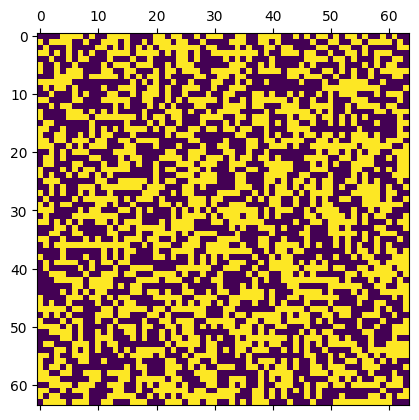

In [ ]:
plt.matshow(X[0].reshape(64,64)), ((X[0]+1)/2).mean(), ((X[0]+1)/2).var()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


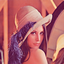

In [ ]:
from PIL import Image

img = Image.open('./lenna.png')
img = img.resize((64,64), Image.ANTIALIAS)
img

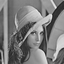

In [ ]:
imggs = img.convert('L')
imggs

activity: 0.488037109375


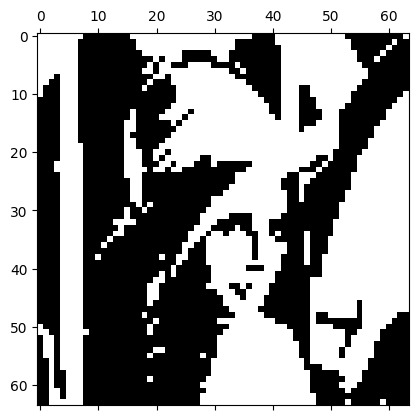

In [ ]:
th_value = 128
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
imgbw = 1 - imgbw
plt.matshow(imgbw, cmap='Greys')
print('activity:', 1 - np.mean(imgbw))
lenna = imgbw.reshape(1, 64*64)*2-1

(10, 4096)


(0.0, 1.1)

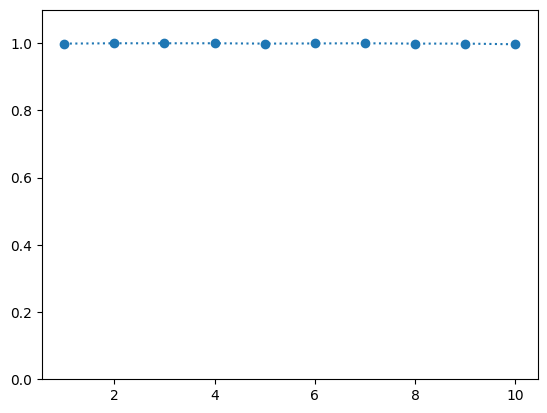

In [ ]:
N = 64*64
K = 100
P = 10
X = np.random.randint(2, size=(P-1, N))*2-1
X = np.concatenate((X, lenna))
print(np.shape(X))

# Generate network structure
C = make_ring(N, K)
# Start W=0
W = np.array([np.zeros(len(C[ni])) for ni in range(N)])
# Hebb learning
for xi in X:
    for ni in range(N):
        W[ni] += xi[C[ni]]*xi[ni]

time = 100
# M: final overlap for each pattern
# store m_i in M for each pattern
M = []
for xi in X:
    states = xi.copy()
    #update network
    m = [(states*xi).mean()]
    for ti in range(time):
        # update all neurons
        states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
        m += [(states*xi).mean()]
        if m[-2] == m[-1]:
            break
    M += [m[-1]]
plt.plot(range(1, P+1), np.abs(M), ':o')
plt.ylim(0,1.1)

array([[-1,  1,  1, ..., -1, -1,  1],
       [-1,  1, -1, ...,  1, -1,  1],
       [-1, -1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1, -1, -1],
       [ 1,  1,  1, ..., -1,  1,  1],
       [ 1, -1, -1, ..., -1, -1,  1]])

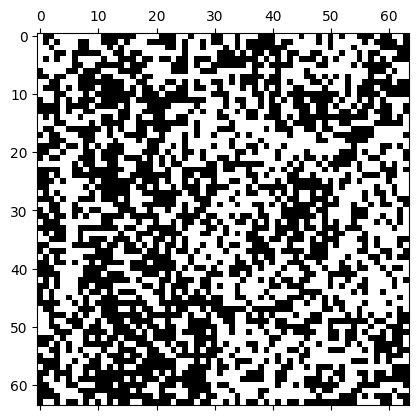

In [ ]:
noise_level = 0.7

noisy_lenna = lenna.copy()

for i in range(np.shape(noisy_lenna)[1]):
    if np.random.random() < noise_level:
        noisy_lenna[0, i] = np.random.randint(2)*2 - 1

plt.matshow(noisy_lenna.reshape((64,64)), cmap='Greys')

noisy_lenna.reshape((64,64))

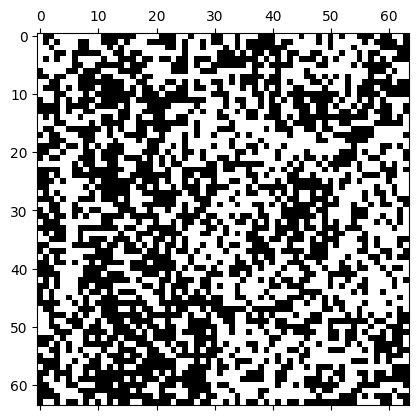

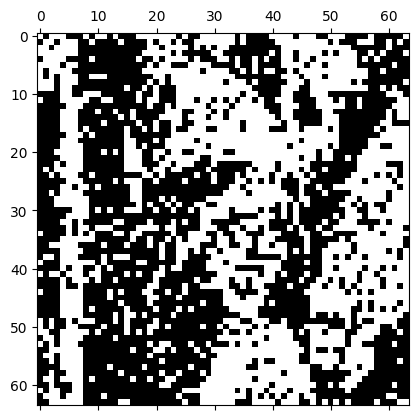

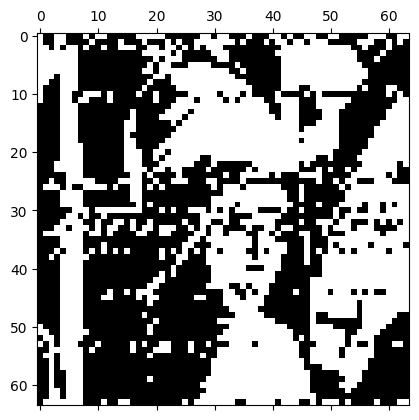

In [ ]:
states = noisy_lenna.flatten()
#update network
m = [(states*X[-1]).mean()]

plt.matshow(states.reshape((64,64)), cmap='Greys')

time = 100
for ti in range(time):
    # update all neurons
    states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
    if not (ti % 50):
        plt.matshow(states.reshape((64,64)), cmap='Greys')
    m += [(states*X[-1]).mean()]

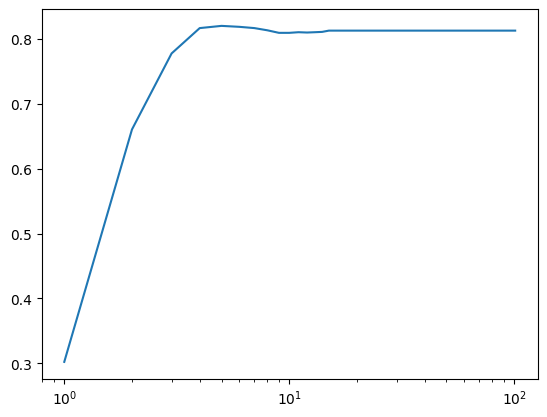

In [ ]:
plt.semilogx(range(1, len(m)+1), m)

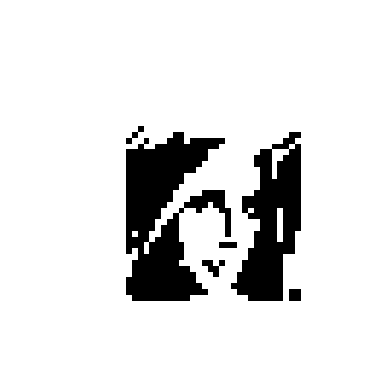

In [ ]:
lenna_rostro = np.zeros((64,64), dtype='int')

lenna_rostro[20:50,20:50] = imgbw[20:50,20:50]

plt.matshow(lenna_rostro, cmap='Greys')
a = plt.axis('off')

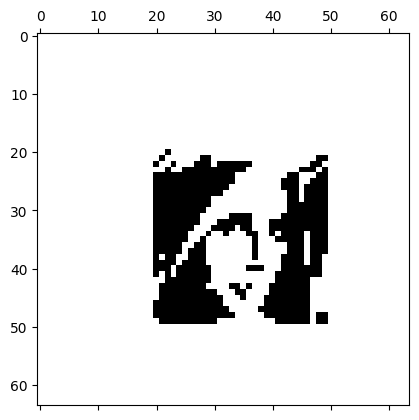

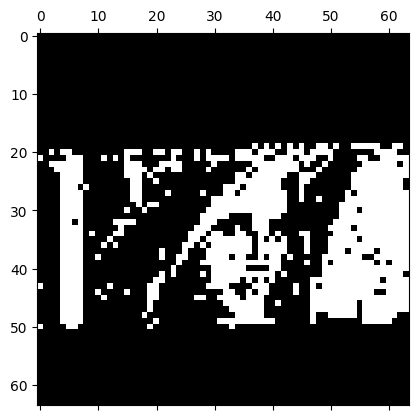

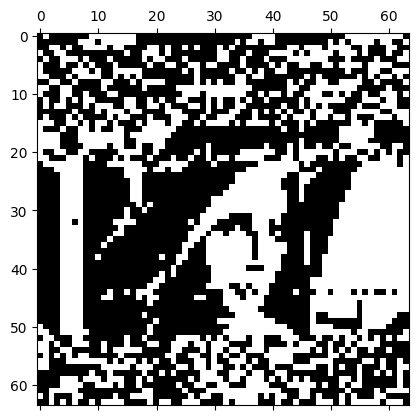

In [ ]:
states = lenna_rostro.flatten()
#update network
m = [(states*X[-1]).mean()]

plt.matshow(states.reshape((64,64)), cmap='Greys')

time = 100
for ti in range(time):
    # update all neurons
    states = np.array([((states[C[ni]]*W[ni]).sum()>=0) for ni in range(N)])*2-1
    if not (ti % 50):
        plt.matshow(states.reshape((64,64)), cmap='Greys')
    m += [(states*X[-1]).mean()]

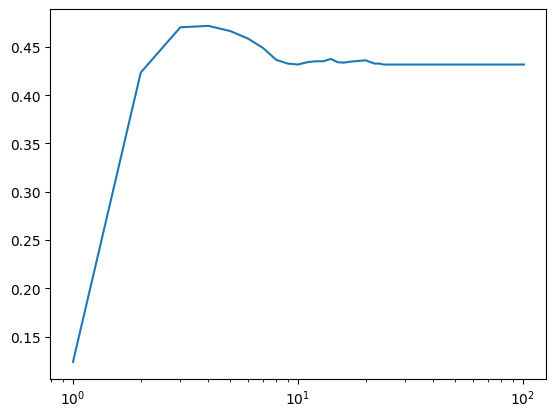

In [ ]:
plt.semilogx(range(1, len(m)+1), m)

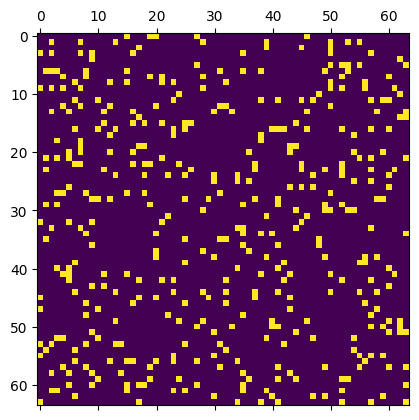

In [ ]:
plt.matshow(bernoulli.rvs(0.1, size=(64,64)))

0.097900390625

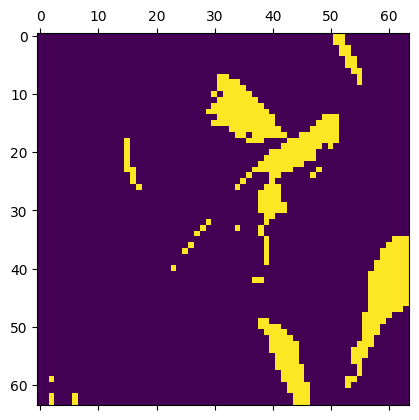

In [ ]:
th_value = 185
imgbw = np.asarray(imggs)
imgbw = (imgbw > th_value)*1
#imgbw = 1 - imgbw
plt.matshow(imgbw)
#print('activity:', 1 - np.mean(imgbw))
lenna = imgbw.reshape(1, 64*64)
lenna.mean()

In [ ]:
N = 64*64
K = 100
P = 10
pattern_activity = 0.1
#X = np.random.randint(2, size=(P, N))*2-1
X = bernoulli.rvs(pattern_activity, size=(P-1, N))
X = np.concatenate((X, lenna))
print(np.shape(X))
# standardize patterns
X_std = (X - X.mean())/X.std()
X.mean(), X.var(), X_std.mean(), X_std.var(), 0.1, 0.1*0.9

(10, 4096)


(0.0993408203125,
 0.08947222173213956,
 5.377642775528102e-17,
 1.0000000000000004,
 0.1,
 0.09000000000000001)

In [ ]:
# Generate network structure
C = make_ring(N, K)
# Start W=0
W = np.array([np.zeros(len(C[ni])) for ni in range(N)])
# Hebb learning with standardized weights
for xi in X_std:
    for ni in range(N):
        W[ni] += xi[C[ni]]*xi[ni]

In [ ]:
# Check: https://github.com/marsgr6/presentations/blob/master/ai_202120/papers/10.1142%40S0129065714500257.pdf

a = 0.1  # X.mean()
A = a*(1-a)  # X.var()
threshold = (1 - 2*a) / (2*np.sqrt(A))
threshold

1.3333333333333333

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(0.0, 1.1)

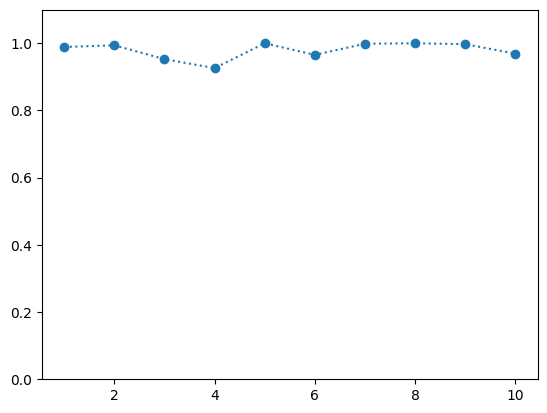

In [ ]:
def std_vec(x):
    return (x - x.mean()) / x.std()

time = 100
# M: final overlap for each pattern
# store m_i in M for each pattern
M = []
for xi in X:
    states = xi.copy()
    #update network
    m = [(std_vec(states)*std_vec(xi)).mean()]
    for ti in range(time):
        # update all neurons
        #standardize neural input and use threshold
        states = np.array([((std_vec(states[C[ni]])*W[ni]).mean() - threshold >= 0) for ni in range(N)])
        m += [(std_vec(states)*std_vec(xi)).mean()]
        if m[-2] == m[-1]:
            break
    M += [m[-1]]
plt.plot(range(1, P+1), np.abs(M), ':o')
plt.ylim(0,1.1)

(0.0, 1.0)

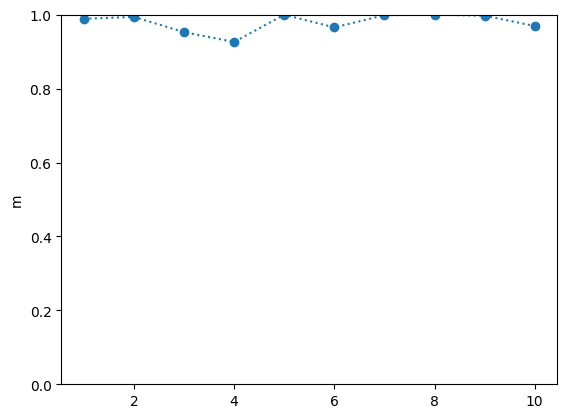

In [ ]:
# This dynamical thrshold is for blocks (image has blocks)
def act_threshold(neighbors, th):
    threshold = th
    if np.mean(neighbors) > 0.5:
        threshold = -th
    return threshold

# Measure the quality of retrieval 
M = []  # M is 1, perfect retrieval, M is 0 no retrieval

#for each pattern x in X
for x in X:
    states = np.copy(x)  # pattern x in time 0
    
    m = [(std_vec(x)*std_vec(states)).mean()]  # initianl overlap in time 0, x is equal to xt, so m=1
    
    # update network for 100 steps
    for ti in range(100):
        # update each neuron states[nxi]
        states = np.array([(np.mean(std_vec(states[C[nxi]])*W[nxi]) 
                        - act_threshold(states[C[nxi]], threshold) >= 0)  # TH(local_field, threshod)
                       if np.var(states[C[nxi]])  # if variance is not zero
                       else states[nxi]  # state does not change otherwise
                       for nxi in range(N)])
        #xt = xt.astype('int')
        m += [(std_vec(x)*std_vec(states)).mean()]  # calculate overlap
        if m[-1] == m[-2]:
            break
    M += [m[-1]]
    
plt.plot(range(1, P+1), np.abs(M), ':o')
plt.ylabel("m")
plt.ylim((0,1))

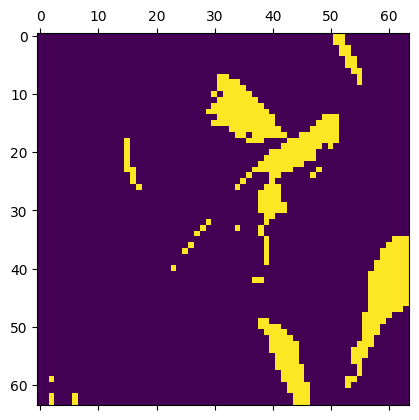

In [ ]:
plt.matshow(X[-1].reshape(64,64))

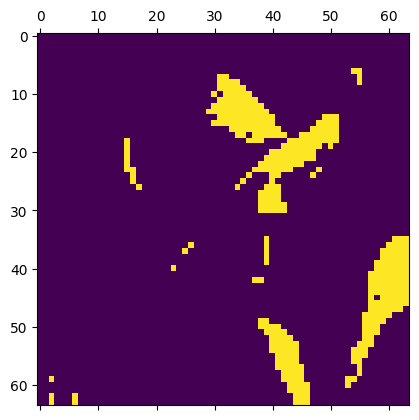

In [ ]:
plt.matshow(states.reshape(64,64))

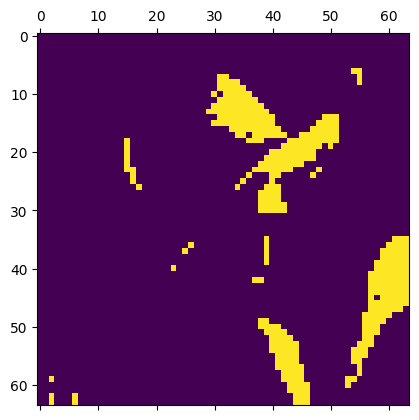

In [ ]:
plt.matshow(states.reshape(64,64))

### Check: 

- Net evolution (step by step): https://github.com/marsgr6/r-scripts/blob/master/notebooks/biased_ann_1.ipynb
- MATLAB implementation: https://web.cs.dal.ca/~tt/fundamentals/programs/MATLAB/Chapter8/
- Check: https://web.cs.dal.ca/~tt/fundamentals/
- Check the paper:  https://github.com/marsgr6/presentations/blob/master/ai_202120/papers/10.1142%40S0129065714500257.pdf

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cce3455d-da08-4c10-a6fe-39f2a30c6a51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>